<a href="https://colab.research.google.com/github/jigjid/github_task/blob/main/Neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**MNIST Dataset**

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

###**Review the dataset**

In [ ]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


###**Smoothing**

In [ ]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


###**Image data visualization**

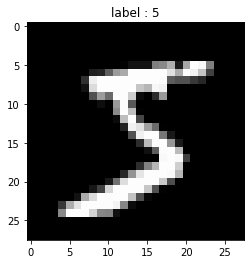

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

<ipython-input-102-f52c77eb23b3>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image.astype(np.float) # float型に変換


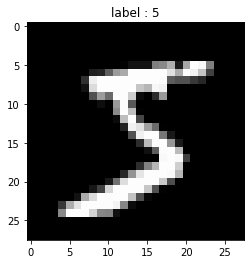

In [ ]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
#print(image) # 値を確認

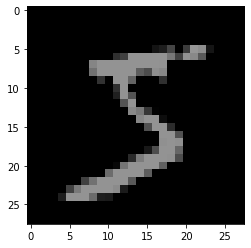

In [ ]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

In [ ]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

###**Problem 1 -5** 

In [ ]:
class ScratchSimpleNeuralNetrowkClassifier():
    def __init__(self,batch_size = 20,n_features = 784,n_nodes1 = 400,n_nodes2 = 200,n_output = 10,sigma = 0.02,lr = 0.01,epoch = 10, verbose=True):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []

        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)


    def fit(self, X, y, X_val=None, y_val=None):
        for _ in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                self.forward(mini_X_train)
                self.backward(mini_X_train, mini_y_train)
            self.forward(X)
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            if X_val is not None:
                self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val)
    

    def forward(self, X):
        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
    
    def backward(self, X, y):
        dA3 = (self.Z3 - y)/self.batch_size
        dW3 = self.Z2.T @ dA3
        dB3 = np.sum(dA3, axis=0)
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        dB2 = np.sum(dA2, axis=0)
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = X.T @ dA1
        dB1 = np.sum(dA1, axis=0)
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
    
    def tanh_function(self, X):
        result = (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        # or
        #  result = np.tanh(X)
        return result
    
    def softmax(self,X):
        result = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return result

    def sigmoid(self,X):
        result = 1 / (1 + np.exp(-X))   
        return result
        
    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        

    def predict(self, X):
        self.forward(X)
        return np.argmax(self.Z3, axis=1)

###**preprocessing**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train data shape: ", X_train.shape) # (60000, 28, 28)
print("X_test data shape: ", X_test.shape) # (10000, 28, 28)

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train flatten data shape: ", X_train.shape) # (60000, 28, 28)
print("X_test flatten data shape: ", X_test.shape) # (10000, 28, 28)

# Preprocessing

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print('X_train max value:', X_train.max()) # 1.0
print('X_train min value:', X_train.min()) # 0.0

# the correct label is an integer from 0 to 9, but it is converted to a one-hot representation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train.reshape(-1,1))
y_val_one_hot = enc.fit_transform(y_val.reshape(-1,1))
print("Train dataset:", X_train.shape) # (48000, 784)
print("Validation dataset:", X_val.shape) # (12000, 784)

X_train data shape:  (60000, 28, 28)
X_test data shape:  (10000, 28, 28)
X_train flatten data shape:  (60000, 784)
X_test flatten data shape:  (10000, 784)
X_train max value: 1.0
X_train min value: 0.0
Train dataset: (48000, 784)
Validation dataset: (12000, 784)


<ipython-input-87-e35d54ce5fbc>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = X_train.astype(np.float)
<ipython-input-87-e35d54ce5fbc>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = X_test.astype(np.float)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was r

###**Problem 6:**Learning and estimation

In [ ]:
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=10)
nn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)
y_pred = nn.predict(X_val)
print(y_pred)

<ipython-input-76-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
<ipython-input-76-b95c4ffc9059>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


[0.4271390830975435, 0.33383748675697406, 0.2957632377176929, 0.27080713999134626, 0.25141805787562477, 0.2342820112162998, 0.21815268138783941, 0.20282012619533965, 0.18847881361797117, 0.175337064366016] [0.4305528368847324, 0.33969879433860756, 0.3036485758722777, 0.2811899206219851, 0.2640906799787063, 0.24887602232168007, 0.2343859536242365, 0.22053078825866884, 0.20760324949787318, 0.19586302624478466]
[3 4 5 ... 5 2 3]


In [ ]:
from sklearn.metrics import accuracy_score
pred_train = nn.predict(X_train)
accuracy = accuracy_score(y_train, pred_train)
print(accuracy)

0.9495208333333334


###**Problem 7:** Learning curve plot

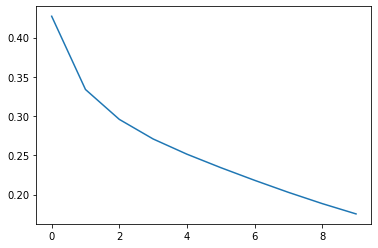

In [ ]:
plt.plot(range(nn.epoch), nn.loss_train)

###**Problem 8:**(Advanced Assignment) Confirmation of misclassification

<ipython-input-95-fc424612851c>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  false_list = np.where(true_false==False)[0].astype(np.int)


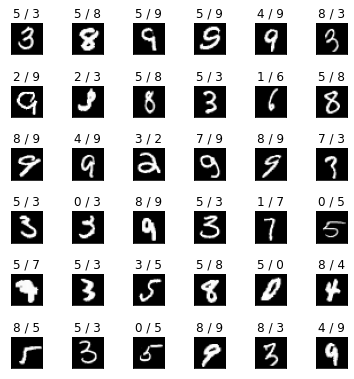

In [ ]:
num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')